In [1]:
import IPython.display as ipd
import glob
from scipy.io import wavfile
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as plt
import matplotlib.pyplot as plt
import struct
from scipy.io import wavfile as wav
import os
from datetime import datetime 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

In [2]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccsscaled

In [3]:
## Label filepath
fulldatasetpath = 'UrbanSound8K/audio/'

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
print(featuresdf)

c:\python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
c:\python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
c:\python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


                                                feature       class_label
0     [-215.79301, 71.66612, -131.81377, -52.091335,...          dog_bark
1     [-424.68677, 110.56227, -54.148235, 62.01074, ...  children_playing
2     [-459.56467, 122.800354, -47.92471, 53.265697,...  children_playing
3     [-414.55377, 102.896904, -36.66495, 54.18041, ...  children_playing
4     [-447.397, 115.0954, -53.809113, 61.60859, 1.6...  children_playing
...                                                 ...               ...
8727  [-399.2257, 136.81903, -51.964222, 37.02399, -...          car_horn
8728  [-346.72733, 87.48847, -46.265022, 52.748833, ...          car_horn
8729  [-304.61316, 112.6199, -47.161945, 37.00349, -...          car_horn
8730  [-344.71423, 126.75813, -56.17717, 36.070927, ...          car_horn
8731  [-315.93384, 95.67589, -38.047768, 47.50074, -...          car_horn

[8732 rows x 2 columns]


In [4]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=6):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        ## x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        
        ## (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs) 
        
        ## (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs) 
        
        ## (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  
        ## (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  
        ## (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  
        ## (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  
        ## (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  
        ## (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  
        ## (batch_size, seq_len, embed_dim)
        return output

In [5]:
class TransformerBlock(layers.Layer):
    ## For calling multihead attention on embedded data and arranging it sequentially and adding other layers.
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
class TokenAndPositionEmbedding(layers.Layer):
    ## For preliminary token generation and embedding
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [7]:
## Generating audio data in the word domain to apply transformer
featuresdf=featuresdf.dropna(axis=0)
print(featuresdf)
X = np.array(featuresdf.feature.tolist())
X=X*100000
min_X=-min([min(element) for element in X])
x=X+min_X
x=x.astype(int)
max_len=max([max(element) for element in x])
print(max_len)
# Getting label size
y = np.array(featuresdf.class_label.tolist())
print(x,x.shape)
print(y,y.shape)

                                                feature       class_label
0     [-215.79301, 71.66612, -131.81377, -52.091335,...          dog_bark
1     [-424.68677, 110.56227, -54.148235, 62.01074, ...  children_playing
2     [-459.56467, 122.800354, -47.92471, 53.265697,...  children_playing
3     [-414.55377, 102.896904, -36.66495, 54.18041, ...  children_playing
4     [-447.397, 115.0954, -53.809113, 61.60859, 1.6...  children_playing
...                                                 ...               ...
8727  [-399.2257, 136.81903, -51.964222, 37.02399, -...          car_horn
8728  [-346.72733, 87.48847, -46.265022, 52.748833, ...          car_horn
8729  [-304.61316, 112.6199, -47.161945, 37.00349, -...          car_horn
8730  [-344.71423, 126.75813, -56.17717, 36.070927, ...          car_horn
8731  [-315.93384, 95.67589, -38.047768, 47.50074, -...          car_horn

[8732 rows x 2 columns]
104338845
[[55124989 83870903 63522914 ... 76536014 76615704 76739729]
 [34235614 87760

In [8]:
from sklearn.model_selection import train_test_split 
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,shuffle=False)
m,n=x.shape
print(m,n)
print(y.shape)
x_train=x[0:int(m*8/10),:]
x_test=x[int(m*8/10):m,:]
y_train=y[0:int(m*8/10)]
y_test=y[int(m*8/10):m]

8732 40
(8732,)


In [9]:
## Changing data type for transformer layers
m,n=x_test.shape
print(m,n)

## Converting form and reshaping
TestX=x_test
TestY=y_test
testy=np.reshape(TestY,(m,))

## Changing datatypes
testx=np.empty((m,),object)
for i in range (0,m):
    testx[i]=list(int(v) for v in TestX[i])
    testy[i]=testy[i].astype(int)

## Printing data-types - relevant to transformer input
print(type(testx))
print(type(testx[m-1][n-1]))
print(type(testx[m-1]))
print(type(testy[m-1]))
print(type(testy))

## Converting Train Data and Getting size of data
m,n=x_train.shape
print(m,n)

## Converting form and reshaping
TrainX=x_train
TrainY=y_train
trainy=np.reshape(TrainY,(m,))

## Changing datatypes
trainx=np.empty((m,),object)
for i in range (0,m):
    trainx[i]=list(int(v) for v in TrainX[i])
    trainy[i]=TrainY[i].astype(int)
    
## Printing data-types - relevant to transformer input
print(type(trainx))
print(type(trainx[m-1][n-1]))
print(type(trainx[m-1]))
print(type(trainy[m-1]))
print(type(trainy))
print(trainx.shape,trainy.shape,testx.shape,testy.shape)

1747 40


ValueError: invalid literal for int() with base 10: 'dog_bark'

In [19]:
vocab_size = max_len+1
maxlen = 40
print(len(trainx), "Training sequences")
print(len(testx), "Validation sequences")

## Converting to padded tensor sequence
trainx = keras.preprocessing.sequence.pad_sequences(trainx,maxlen=maxlen)
testx = keras.preprocessing.sequence.pad_sequences(testx,maxlen=maxlen)
print(trainx.shape,trainy.shape,testx.shape,testy.shape)
print(trainx,trainy,testx,testy)

26004 Training sequences
6502 Validation sequences
(26004, 128) (26004,) (6502, 128) (6502,)
[[      0       0       0 ... 8000000 8000000 8000000]
 [      0       0       0 ... 1371282       0       0]
 [      0       0       0 ... 3634207 1590910 3282813]
 ...
 [      0       0       0 ...       0 3845508 4085073]
 [      0       0       0 ... 5656319 1849492 6239028]
 [      0       0       0 ... 5913697 1944045 4027557]] [0 0 0 ... 0 0 0] [[      0       0       0 ... 4170817       0 6011002]
 [      0       0       0 ... 3987894       0 4175779]
 [      0       0       0 ...       0 1885132 2098962]
 ...
 [      0       0       0 ... 2080015 6158977 6748958]
 [      0       0       0 ... 2138845 1894150 6228027]
 [      0       0       0 ...       0 2186414 6707616]] [0 0 0 ... 0 0 0]


In [20]:
embed_dim = 30  ## Embedding size for each token
num_heads = 6  ## Number of attention heads
ff_dim = 30  ## Hidden layer size in feed forward network inside transformer

## Tokenizing input data with max dimension and embedding it
inputs = layers.Input(shape=(maxlen,))
#x = keras.Sequential()
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

## Adding Sequential layer to the embedded data and attention layers too.
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

## Add other layers
x = layers.Conv1D(10,1000,maxlen,padding="same")(x)


In [21]:
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)

## Producing general softmax layer for classification
outputs = layers.Dense(10, activation="softmax")(x)

## Generating model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
token_and_position_embedding (None, 128, 30)           240003870 
_________________________________________________________________
transformer_block (Transform (None, 128, 30)           5700      
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 10)             300010    
_________________________________________________________________
dense_6 (Dense)              (None, 1, 30)             330       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 30)            

In [22]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(trainx, trainy, batch_size=100, epochs=100, validation_data=(testx,testy))

Epoch 1/100
261/261 [==============================] - 536s 2s/step - loss: 0.9559 - accuracy: 0.7976 - val_loss: 0.7090 - val_accuracy: 0.8685
Epoch 2/100
261/261 [==============================] - 535s 2s/step - loss: 0.7005 - accuracy: 0.8366 - val_loss: 0.6537 - val_accuracy: 0.8685
Epoch 3/100
261/261 [==============================] - 535s 2s/step - loss: 0.4113 - accuracy: 0.8656 - val_loss: 0.8583 - val_accuracy: 0.8302
Epoch 4/100
261/261 [==============================] - 537s 2s/step - loss: 0.2964 - accuracy: 0.8855 - val_loss: 1.4885 - val_accuracy: 0.5365
Epoch 5/100
261/261 [==============================] - 550s 2s/step - loss: 0.2534 - accuracy: 0.8921 - val_loss: 1.7432 - val_accuracy: 0.5058
Epoch 6/100
261/261 [==============================] - 548s 2s/step - loss: 0.2117 - accuracy: 0.8944 - val_loss: 1.8860 - val_accuracy: 0.2396
Epoch 7/100
261/261 [==============================] - 548s 2s/step - loss: 0.1880 - accuracy: 0.9092 - val_loss: 1.9609 - val_accuracy:

KeyboardInterrupt: 

In [23]:
score = model.evaluate(trainx, trainy, verbose=0)
print("Training Performance",score)
score = model.evaluate(testx, testy, verbose=0)
print("Testing Performance",score)

Training Performance [3.3970255851745605, 0.24300214648246765]
Testing Performance [3.3970255851745605, 0.24300214648246765]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


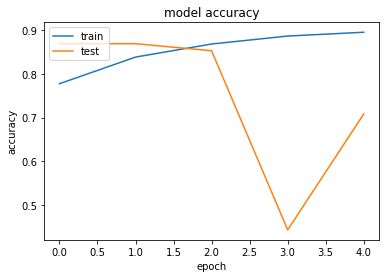

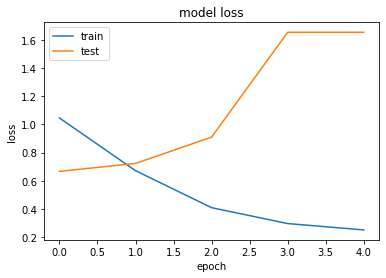

In [40]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
keras.backend.clear_session()

In [42]:
del model